In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.insert(0, '../../')
sys.path.insert(0, '../preprocessing/')
sys.path.insert(0, '..')
import ESM_utils as esm
import os
import glob
import shutil

import plotly.plotly as py
import plotly.graph_objs as go

import os
import pandas as pd
import numpy as np
import nibabel as ni
import itertools
from glob import glob
import statsmodels.distributions.empirical_distribution as ed
import matplotlib.pyplot as plt
import math
import seaborn as sns
from scipy import stats
from scipy.io import savemat,loadmat
from nilearn import input_data, image
from matplotlib import mlab
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import MinMaxScaler
from statsmodels.sandbox.stats.multicomp import multipletests

In [2]:
appian_suvr_mutcarriers = pd.read_csv("/data1/llevitis/DIAN/csv_files/20190408_appian_suvr_mutcarriers.csv", index_col=0)
roi_cols = appian_suvr_mutcarriers.columns[0:78]

In [3]:
mattsson_early_acc_cols = []
for i, roi in enumerate(roi_cols): 
    if "Medial orbitofrontal" in roi or "Posterior cingulate" in roi or "Precuneus" in roi: 
        print(i, roi)
        mattsson_early_acc_cols.append(roi)

11 Left Medial orbitofrontal
20 Left Posterior cingulate
22 Left Precuneus
50 Right Medial orbitofrontal
59 Right Posterior cingulate
61 Right Precuneus


In [4]:
mattsson_early_acc_cols

['Left Medial orbitofrontal',
 'Left Posterior cingulate',
 'Left Precuneus',
 'Right Medial orbitofrontal',
 'Right Posterior cingulate',
 'Right Precuneus']

In [5]:
adni_appian_suvr_voxelwise_ecdf_esm2014method = pd.read_csv("/data1/llevitis/DIAN/csv_files/20190704_adni_appian_suvr_voxelwise_ecdf.csv", index_col=0)

In [6]:
adni_pet_probabilities_esm2014 = esm.loadmat("/data1/llevitis/DIAN/csv_files/ABeta_data_ESM_study2014.mat")

In [7]:
adni_appian_suvr_voxelwise_ecdf_esm2014method.head()

,Left Caudal anterior cingulate,Left Caudal middle frontal,Left Cuneus,Left entorinal,Left fusiform,Left Inferior parietal,Left Inferior temporal,Left Isthmus cingulate,Left Lateral Occipital,Left Lateral orbitofronal,...,Right Transverse temporal,Right Insula,Right Basal forebrain,Right Amygdala,Right Hypothalamus,Right Caudate,Right Hippocampus,Right Globus Pallidus,Right Putamen,Right Thalamus
ADNI002S2043,0.949761,0.873250,0.986965,0.190364,0.493833,0.834926,0.302108,0.732347,0.783579,0.776623,...,0.543593,0.723565,0.442958,0.432500,0.396421,0.348749,0.607239,0.979308,0.839800,0.473539
ADNI002S2073,0.663965,0.692820,0.689847,0.218036,0.632110,0.778381,0.521745,0.795583,0.700407,0.807825,...,0.593236,0.716242,0.512191,0.364942,0.282565,0.534471,0.584928,0.959835,0.773238,0.368419
ADNI002S4213,0.695950,0.406017,0.410337,0.145818,0.429521,0.368873,0.249713,0.502774,0.505025,0.530019,...,0.050922,0.508376,0.016555,0.246690,0.047845,0.021728,0.532209,0.979611,0.658962,0.351134
ADNI002S4219,0.519446,0.444851,0.479106,0.342250,0.491676,0.427826,0.338970,0.562889,0.616512,0.649365,...,0.192145,0.480703,0.153692,0.455964,0.154009,0.095644,0.689283,0.999268,0.953869,0.428870
ADNI002S4225,0.985726,0.840500,0.611226,0.391386,0.878533,0.863405,0.705987,0.748803,0.676365,0.777392,...,1.000000,0.996193,0.734678,0.759500,0.487691,0.492707,0.942088,1.000000,0.997974,0.584133


In [49]:
adni_pet_probabilities_esm2014['ref_pattern_EMCI'].shape

(78, 233)

In [8]:
adni_pet_probabilities_esm2014.keys()

dict_keys(['__header__', '__version__', '__globals__', 'AGEs', 'EDUs', 'MMSEs', 'RIDs', 'SEXs', 'group_indices', 'measure', 'ref_pattern_AD', 'ref_pattern_EMCI', 'ref_pattern_LMCI', 'ref_pattern_MCI', 'ref_pattern_NORMAL', 'ref_pattern_all_subjects'])

In [9]:
adni_pet_probabilities_esm2014['group_indices']

array([[  1, 111],
       [112, 307],
       [308, 311],
       [312, 544],
       [545, 737]], dtype=uint16)

In [10]:
group_idx = adni_pet_probabilities_esm2014['group_indices']

In [11]:
adni_pet_probabilities_esm2014['ref_pattern_LMCI'].shape

(78, 196)

In [12]:
307-112

195

In [13]:
group_idx_dict = {} 
group_idx_dict['AD'] = list(range(group_idx[0][0], group_idx[0][1]))
group_idx_dict['EMCI'] = list(range(group_idx[3][0], group_idx[3][1]))
group_idx_dict['LMCI'] = list(range(group_idx[1][0], group_idx[1][1]))
group_idx_dict['MCI'] = list(range(group_idx[2][0], group_idx[2][1]))
group_idx_dict['CN'] = list(range(group_idx[4][0], group_idx[4][1]))

In [14]:
545 in group_idx_dict['CN']

True

In [15]:
adni_pet_probabilities_esm2014['ref_pattern_all_subjects'].shape

(78, 737)

In [16]:
adni_pet_probabilities_esm2014_df = pd.DataFrame(adni_pet_probabilities_esm2014['ref_pattern_all_subjects'])
adni_pet_probabilities_esm2014_df = adni_pet_probabilities_esm2014_df.transpose()

In [17]:
adni_pet_probabilities_esm2014_df.index = adni_pet_probabilities_esm2014['RIDs'][0]
adni_pet_probabilities_esm2014_df.columns = roi_cols

In [18]:
roi_cols

Index(['Left Caudal anterior cingulate', 'Left Caudal middle frontal',
       'Left Cuneus', 'Left entorinal', 'Left fusiform',
       'Left Inferior parietal', 'Left Inferior temporal',
       'Left Isthmus cingulate', 'Left Lateral Occipital',
       'Left Lateral orbitofronal', 'Left Lingual gyrus',
       'Left Medial orbitofrontal', 'Left Middle temporal',
       'Left Parahippocampal', 'Left Paracentral ', 'Left Pars opercularis',
       'Left Pars orbitalis', 'Left Pars triangularis', 'Left Pericalcarine',
       'Left Postcentral', 'Left Posterior cingulate', 'Left Precentral',
       'Left Precuneus', 'Left Rostral anterior cingulate',
       'Left Rostral middle frontal', 'Left Superior frontal',
       'Left Superior parietal', 'Left Superior Temporal',
       'Left Supramarginal', 'Left Transverse temporal', 'Left Insula',
       'Left Basal forebrain', 'Left Amygdala', 'Left Hypothalamus???',
       'Left Caudate', 'Left Hippocampus', 'Left Globus Pallidus',
       'Left P

In [19]:
for i, roi in enumerate(roi_cols): 
    if "Caudal anterior cingulate" in roi or  "Posterior cingulate" in roi: 
        print(i+1, roi)

1 Left Caudal anterior cingulate
21 Left Posterior cingulate
40 Right Caudal anterior cingulate
60 Right Posterior cingulate


In [20]:
i = 1 
for sub in adni_pet_probabilities_esm2014_df.index: 
    adni_pet_probabilities_esm2014_df.loc[sub, 'esm_idx'] = int(i)
    i += 1

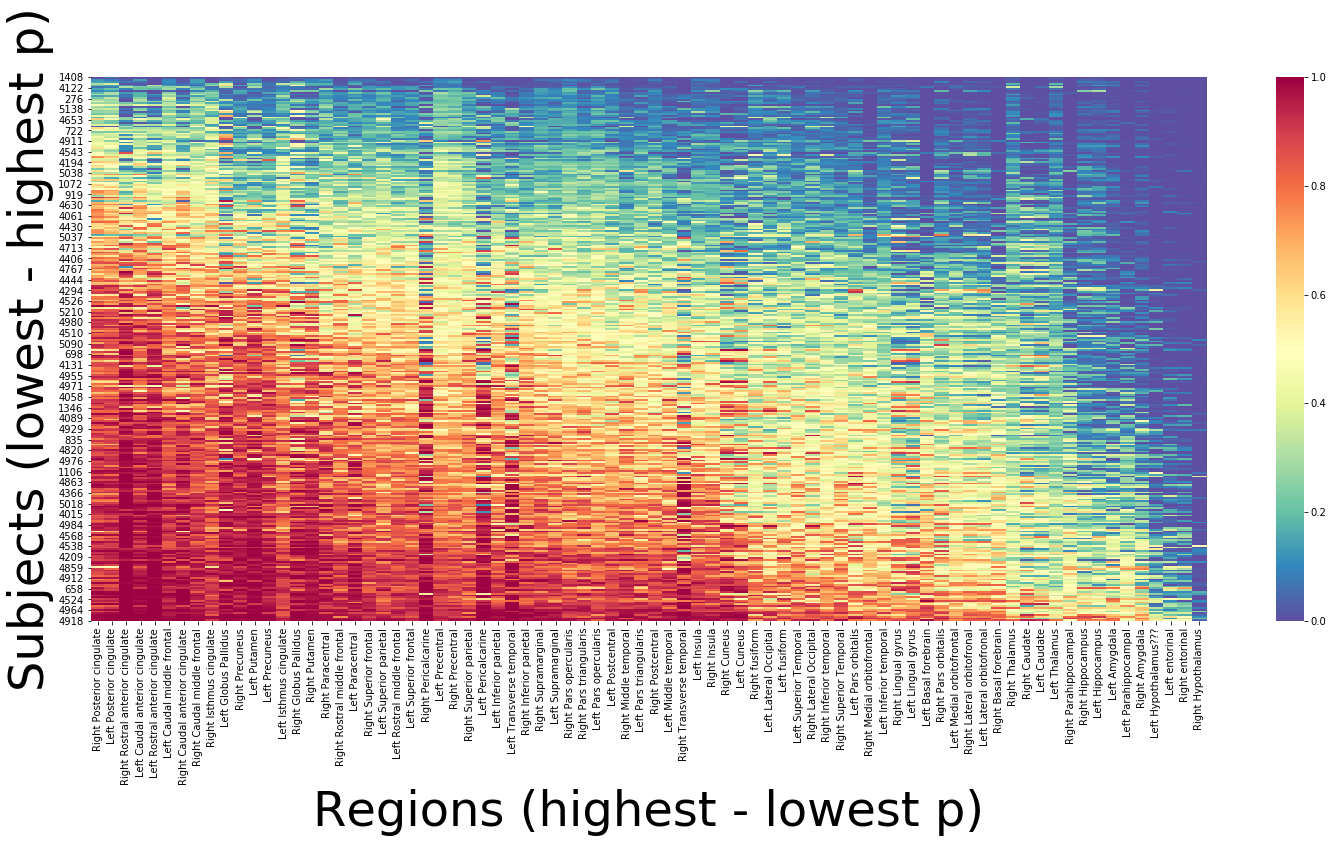

Index(['Right Posterior cingulate', 'Left Posterior cingulate',
       'Right Rostral anterior cingulate', 'Left Caudal anterior cingulate',
       'Left Rostral anterior cingulate', 'Left Caudal middle frontal',
       'Right Caudal anterior cingulate', 'Right Caudal middle frontal',
       'Right Isthmus cingulate', 'Left Globus Pallidus', 'Right Precuneus',
       'Left Putamen', 'Left Precuneus', 'Left Isthmus cingulate',
       'Right Globus Pallidus', 'Right Putamen', 'Right Paracentral ',
       'Right Rostral middle frontal', 'Left Paracentral ',
       'Right Superior frontal', 'Left Superior parietal',
       'Left Rostral middle frontal', 'Left Superior frontal',
       'Right Pericalcarine', 'Left Precentral', 'Right Precentral',
       'Right Superior parietal', 'Left Pericalcarine',
       'Left Inferior parietal', 'Left Transverse temporal',
       'Right Inferior parietal', 'Right Supramarginal', 'Left Supramarginal',
       'Right Pars opercularis', 'Right Pars triangu

In [21]:
esm.Plot_Probabilites(adni_pet_probabilities_esm2014_df[adni_pet_probabilities_esm2014_df.esm_idx < 308].loc[:, roi_cols], figsize=(25,10), cmap='Spectral_r')

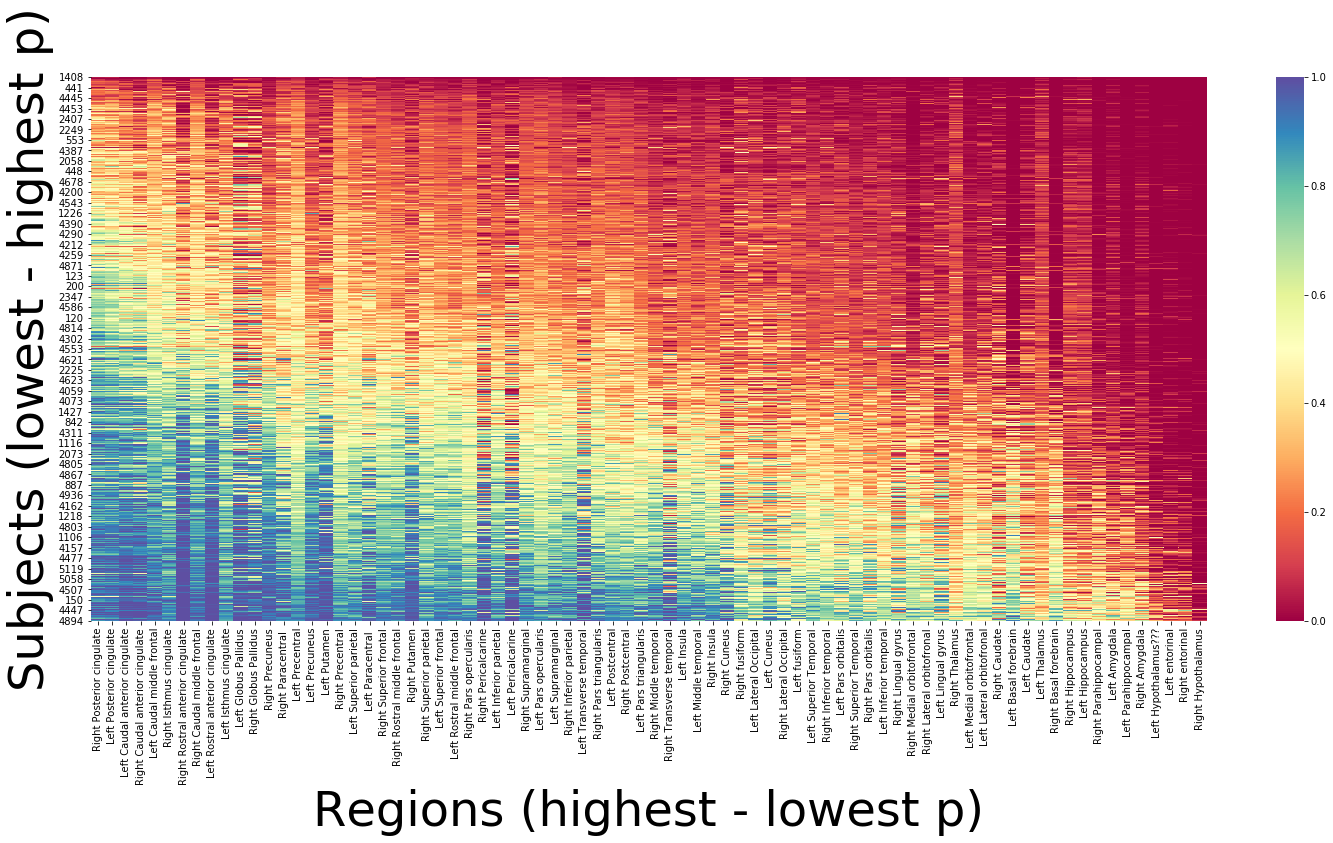

Index(['Right Posterior cingulate', 'Left Posterior cingulate',
       'Left Caudal anterior cingulate', 'Right Caudal anterior cingulate',
       'Left Caudal middle frontal', 'Right Isthmus cingulate',
       'Right Rostral anterior cingulate', 'Right Caudal middle frontal',
       'Left Rostral anterior cingulate', 'Left Isthmus cingulate',
       'Left Globus Pallidus', 'Right Globus Pallidus', 'Right Precuneus',
       'Right Paracentral ', 'Left Precentral', 'Left Precuneus',
       'Left Putamen', 'Right Precentral', 'Left Superior parietal',
       'Left Paracentral ', 'Right Superior frontal',
       'Right Rostral middle frontal', 'Right Putamen',
       'Right Superior parietal', 'Left Superior frontal',
       'Left Rostral middle frontal', 'Right Pars opercularis',
       'Right Pericalcarine', 'Left Inferior parietal', 'Left Pericalcarine',
       'Right Supramarginal', 'Left Pars opercularis', 'Left Supramarginal',
       'Right Inferior parietal', 'Left Transverse tempo

In [22]:
esm.Plot_Probabilites(adni_pet_probabilities_esm2014_df[roi_cols], figsize=(25,10), cmap='Spectral')

In [23]:
adni_pet_probabilities_esm2014_ages = list(adni_pet_probabilities_esm2014['AGEs'].flatten())

In [24]:
adni_pet_probabilities_esm2014_ages

[73.3,
 66.7,
 60.7,
 71.1,
 68.0,
 81.4,
 81.5,
 77.0,
 79.3,
 82.2,
 71.0,
 74.4,
 70.7,
 74.5,
 72.8,
 75.5,
 67.3,
 71.0,
 68.0,
 75.7,
 69.2,
 78.1,
 76.0,
 55.9,
 86.5,
 55.6,
 65.9,
 77.5,
 75.2,
 73.0,
 86.5,
 82.1,
 79.0,
 76.3,
 62.9,
 78.5,
 77.3,
 79.0,
 81.0,
 75.8,
 72.7,
 74.0,
 77.7,
 80.1,
 80.9,
 78.5,
 55.9,
 68.3,
 84.3,
 64.6,
 85.6,
 60.7,
 71.5,
 74.3,
 85.8,
 88.5,
 75.9,
 79.6,
 69.3,
 87.3,
 77.5,
 71.0,
 72.2,
 83.2,
 79.1,
 70.9,
 58.8,
 79.6,
 73.7,
 89.6,
 74.3,
 64.0,
 74.1,
 87.8,
 62.2,
 77.7,
 80.5,
 63.8,
 77.2,
 79.4,
 71.1,
 71.7,
 90.3,
 63.7,
 61.9,
 85.3,
 61.8,
 80.6,
 65.9,
 78.7,
 85.8,
 80.3,
 73.6,
 77.2,
 81.1,
 76.4,
 73.1,
 60.6,
 68.2,
 72.1,
 60.6,
 71.5,
 78.8,
 70.0,
 61.1,
 77.8,
 80.9,
 75.8,
 66.8,
 84.2,
 75.8,
 65.1,
 66.4,
 71.9,
 70.0,
 75.4,
 71.2,
 62.9,
 61.2,
 85.0,
 75.7,
 71.9,
 75.1,
 85.5,
 79.4,
 71.1,
 71.3,
 73.5,
 74.6,
 70.5,
 59.6,
 73.6,
 74.3,
 66.9,
 67.4,
 62.8,
 76.7,
 70.1,
 61.6,
 77.2,
 73.6,
 60.0,
 83.2,

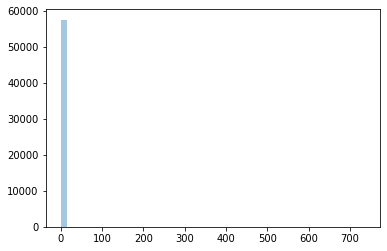

In [25]:
sns.distplot(adni_pet_probabilities_esm2014_df.values.flatten(), kde=False)

In [26]:
output_dir = '/data1/llevitis/DIAN_ESM_ABeta_Analysis/data/ADNI/esm_output_mat_files//'
conn_matrices = ['/Users/liza/data/DIAN/connectivity_CMU60DSI/Matrix_ACP.mat', '/Users/liza/data/DIAN/connectivity_CMU60DSI/Matrix_LONG.mat']
conn_mat_names = ['Map', 'Map']
conn_out_names = ['ACP', 'LONG']

In [27]:
#prob_matrices = adni_pet_probabilities_esm2014_df
#file_names = '20190709_adni_pet_probabilities_esm2014.mat'
#esm.Prepare_Inputs_for_ESM({'test_data': adni_pet_probabilities_esm2014_df[roi_cols]}, adni_pet_probabilities_esm2014_ages, output_dir, file_names, 
#                                     conn_matrices, conn_mat_names, conn_out_names)  

In [28]:
adni_pet_probabilities_esm2014_res_mat = esm.loadmat("/data1/llevitis/DIAN/20190709_adni_pet_probabilities_esm2014_DMN_09-Jul-2019.mat")

average r2 =  0.3912161197566827
average RMSE = 0.15491492351809796
average eval = 0.9171023374892783


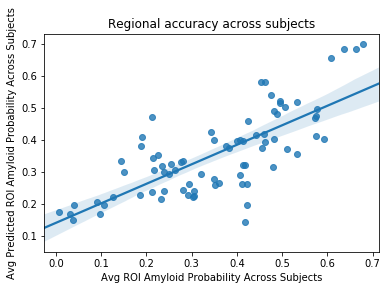

r2 =  0.5579367281507582 /n


/data1/llevitis/miniconda3/envs/clinicaEnv/lib/python3.6/site-packages/seaborn/categorical.py:3666: UserWarning:

The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.



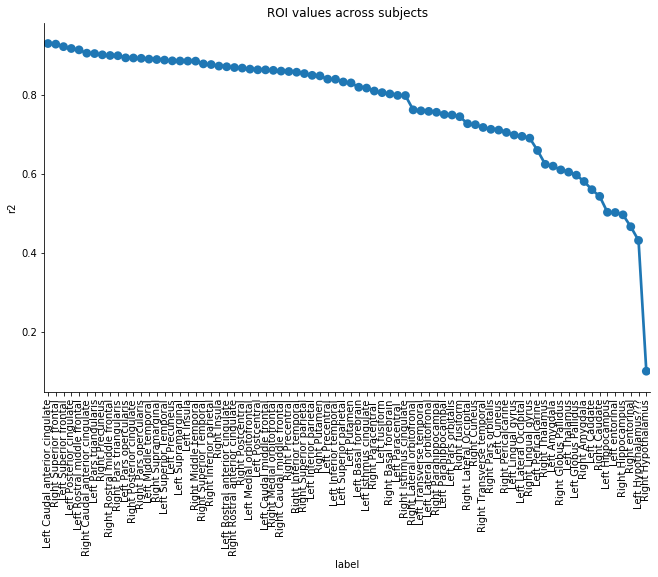

0.7737482503503457


In [29]:
adni_pet_probabilities_esm2014_res = esm.Evaluate_ESM_Results("/data1/llevitis/DIAN/20190709_adni_pet_probabilities_esm2014_DMN_09-Jul-2019.mat", sids=adni_pet_probabilities_esm2014_df.index, labels=roi_cols, lit=True)

In [30]:
model_output = adni_pet_probabilities_esm2014_res['model_output']

In [31]:
i = 1
for idx in model_output.index:
    esm_idx = i
    for key in group_idx_dict: 
        if esm_idx in group_idx_dict[key]: 
            clinical_cat = key 
    model_output.loc[idx, 'esm_idx'] = i
    model_output.loc[idx, 'ClinicalCategory'] = clinical_cat
    i += 1

In [32]:
betas_est = adni_pet_probabilities_esm2014_res_mat['BETAS_est'].flatten()
deltas_est = adni_pet_probabilities_esm2014_res_mat['DELTAS_est'].flatten()

In [33]:
model_output['betas_est'] = betas_est
model_output['deltas_est'] = deltas_est
model_output['bdr'] = betas_est/deltas_est 
model_output['bdr_log'] = np.log(betas_est/deltas_est)

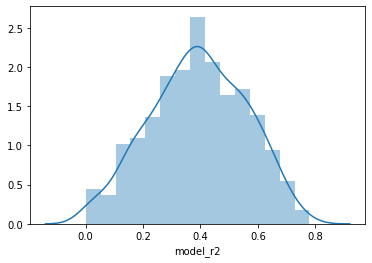

In [34]:
sns.distplot(model_output.model_r2)

In [35]:
for sub in model_output.index: 
    avg_mattsson_roi_deposition = 0
    for roi in mattsson_early_acc_cols: 
        avg_mattsson_roi_deposition += adni_pet_probabilities_esm2014_df.loc[sub, roi] 
    avg_mattsson_roi_deposition = avg_mattsson_roi_deposition / len(mattsson_early_acc_cols) 
    model_output.loc[sub, 'avg_mattsson_roi_deposition'] = avg_mattsson_roi_deposition

In [36]:
model_output.head()

,model_r,model_r2,model_RMSE,model_eval,beta,delta,sigma,ref_age,times,Onset_age,esm_idx,ClinicalCategory,betas_est,deltas_est,bdr,bdr_log,avg_mattsson_roi_deposition
5018,0.645681,0.416903,0.195449,0.579321,0.0405,100.0000,0.0,73.3,20.367123,52.932877,1.0,AD,0.019979,0.01,1.997937,0.692115,0.745466
4136,0.520017,0.270418,0.168200,0.673174,0.9337,7.1372,0.0,66.7,22.726027,43.973973,2.0,AD,0.350002,0.14,2.500019,0.916298,0.487347
4152,0.388894,0.151238,0.246117,0.460057,0.9337,7.1372,0.0,60.7,23.243836,37.456164,3.0,AD,0.350002,0.14,2.500019,0.916298,0.718739
4373,0.408261,0.166677,0.230373,0.491497,0.3343,100.0000,0.0,71.1,6.213699,64.886301,4.0,AD,0.149982,0.01,14.998205,2.707931,0.651665
4707,0.599273,0.359128,0.151523,0.747262,0.7291,100.0000,0.0,68.0,3.452055,64.547945,5.0,AD,0.290005,0.01,29.000535,3.367314,0.442389


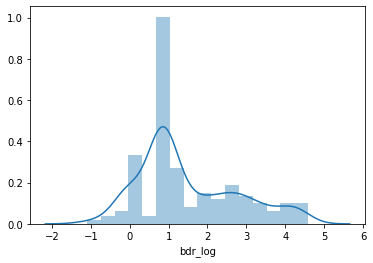

In [37]:
sns.distplot(model_output.bdr_log)

Text(6.674999999999997, 0.5, 'Beta Delta Ratio')

<Figure size 720x720 with 0 Axes>

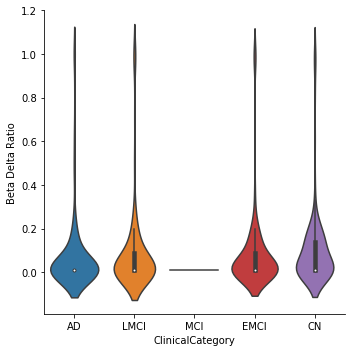

In [38]:
plt.figure(figsize=(10,10))
g = sns.catplot(x="ClinicalCategory", y="deltas_est", data=model_output, kind="violin")
plt.ylabel("Beta Delta Ratio")

In [39]:
model_output_nomci = model_output[model_output.ClinicalCategory != "MCI"]

Text(0, 0.5, 'Average Deposition in Mattson Early Acc ROIs')

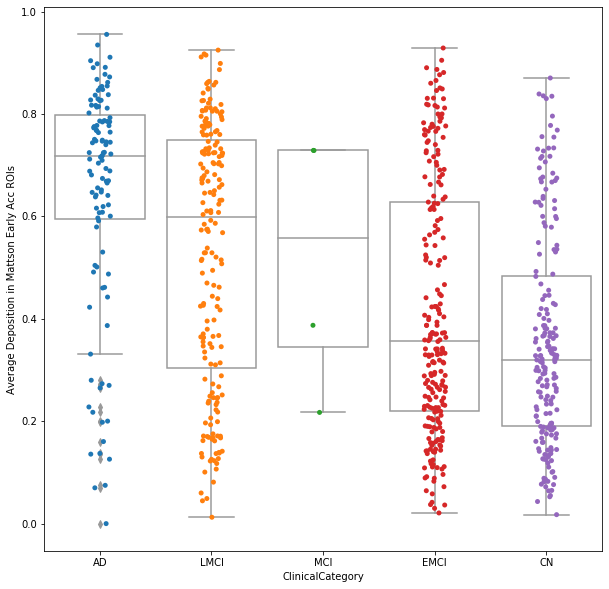

In [40]:
plt.figure(figsize=(10,10))
#g = sns.catplot(x="ClinicalCategory", y="deltas_est", data=model_output, kind="box")
g = sns.boxplot(x="ClinicalCategory", y="avg_mattsson_roi_deposition", data=model_output, color='white')
sns.stripplot(x="ClinicalCategory", y="avg_mattsson_roi_deposition", data=model_output)
plt.ylabel("Average Deposition in Mattson Early Acc ROIs")

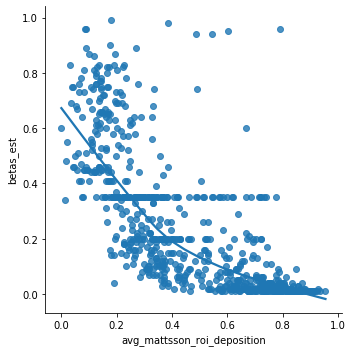

In [41]:
sns.lmplot(x="avg_mattsson_roi_deposition", y="betas_est", data=model_output, lowess=True)

In [42]:
np.mean(model_output[model_output.ClinicalCategory == "CN"].delta)

57.897490673575135

(0, 1)

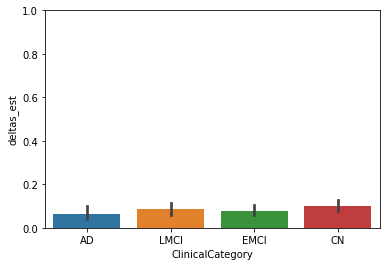

In [47]:
sns.barplot(x="ClinicalCategory", y="deltas_est", data=model_output[model_output.ClinicalCategory != "MCI"])
plt.ylim(0,1)

(0, 1)

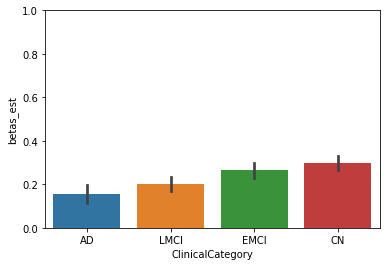

In [48]:
sns.barplot(x="ClinicalCategory", y="betas_est", data=model_output[model_output.ClinicalCategory != "MCI"])
plt.ylim(0,1)

Text(0, 0.5, 'Betas')

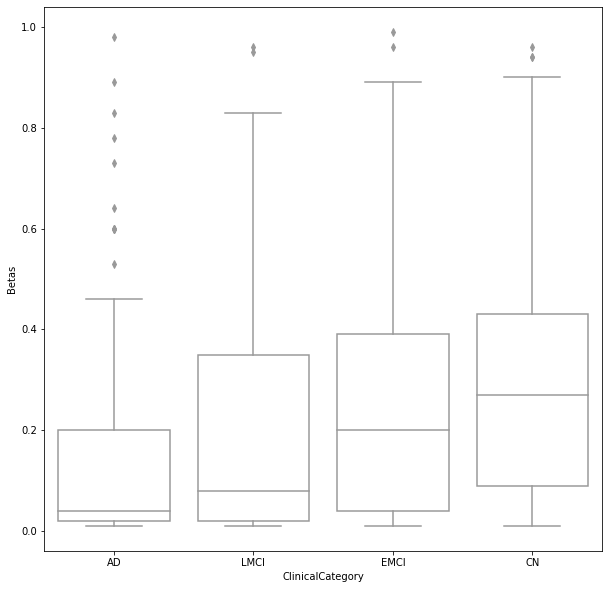

In [46]:
plt.figure(figsize=(10,10))
#g = sns.catplot(x="ClinicalCategory", y="deltas_est", data=model_output, kind="box")
g = sns.boxplot(x="ClinicalCategory", y="betas_est", data=model_output[model_output.ClinicalCategory != "MCI"], color='white')
#sns.stripplot(x="ClinicalCategory", y="deltas_est", data=model_output)
plt.ylabel("Betas")

In [56]:
np.mean(model_output[model_output.ClinicalCategory == 'CN'].Onset_age)

61.50895734260771

In [57]:
np.mean(model_output[model_output.ClinicalCategory == 'AD'].Onset_age)

55.97576206343329

In [58]:
np.mean(model_output[model_output.ClinicalCategory == 'LMCI'].Onset_age)

56.15327788649706

In [59]:
np.mean(model_output[model_output.ClinicalCategory == 'EMCI'].Onset_age)

58.06033864424716

In [60]:
model_output.columns

Index(['model_r', 'model_r2', 'model_RMSE', 'model_eval', 'beta', 'delta',
       'sigma', 'ref_age', 'times', 'Onset_age', 'esm_idx', 'ClinicalCategory',
       'betas_est', 'deltas_est', 'bdr', 'bdr_log'],
      dtype='object')

In [61]:
import statsmodels
import statsmodels.api as sm
from statsmodels.formula.api import ols

/anaconda3/envs/jpserver/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning:

The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.



In [55]:
# Feature Importance
from sklearn import datasets
from sklearn import metrics
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
#import shap

In [56]:
# load the iris datasets
# fit an Extra Trees model to the data
X = model_output_nomci[['betas_est', 'deltas_est', 'ref_age']]
y = model_output_nomci.ClinicalCategory
np.random.seed(seed = 42)
X['random'] = np.random.random(size = len(X))
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.8, random_state = 42)
model = ExtraTreesClassifier()
model.fit(X, y)
# display the relative importance of each attribute
print(model.feature_importances_)

[0.21082717 0.07534047 0.36742241 0.34640995]


/data1/llevitis/miniconda3/envs/clinicaEnv/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/data1/llevitis/miniconda3/envs/clinicaEnv/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.



In [57]:
print('R^2 Training Score: {:.2f} \nR^2 Validation Score: {:.2f}'.format(model.score(X_train, y_train), 
                                                                         model.score(X_valid, y_valid)))

R^2 Training Score: 1.00 
R^2 Validation Score: 1.00


/data1/llevitis/miniconda3/envs/clinicaEnv/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

/data1/llevitis/miniconda3/envs/clinicaEnv/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:459: FutureWarning:

Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.



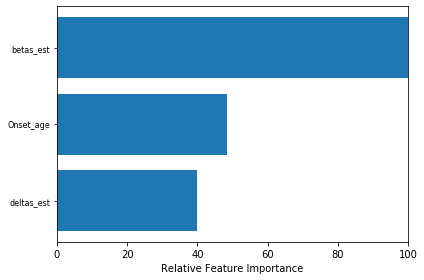

In [58]:
#Scale your data
scaler = MinMaxScaler()
X = model_output_nomci[['betas_est', 'deltas_est', 'Onset_age']]
scaler.fit(X) 
y = model_output_nomci.ClinicalCategory
X_scaled = pd.DataFrame(scaler.transform(X),columns = X.columns)

clf = LogisticRegression(random_state = 0)
clf.fit(X_scaled, y)

feature_importance = abs(clf.coef_[0])
feature_importance = 100.0 * (feature_importance)
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

featfig = plt.figure()
featax = featfig.add_subplot(1, 1, 1)
featax.barh(pos, feature_importance[sorted_idx], align='center')
plt.xlim(0,100)
featax.set_yticks(pos)
featax.set_yticklabels(np.array(X.columns)[sorted_idx], fontsize=8)
featax.set_xlabel('Relative Feature Importance')

plt.tight_layout()   
plt.show()

In [59]:
model = LogisticRegression(penalty="l1", C=0.1)
model.fit(X_scaled, y)

/data1/llevitis/miniconda3/envs/clinicaEnv/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

/data1/llevitis/miniconda3/envs/clinicaEnv/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:459: FutureWarning:

Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.



LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [68]:
clf.score(X_scaled,y)

0.37244201909959074

### Compare Yasser's processed data & the APPIAN processed data

In [ ]:
for i in roi_cols: 
    sns.distplot(adni_appian_suvr_voxelwise_ecdf_esm2014method[i])
    sns.distplot(adni_pet_probabilities_esm2014_df[i]) 
    plt.title(i)
    plt.show()

### Compare Yasser's processed data & the PUP processed data

In [ ]:
dian_pup_1t_df = pd.read_csv("/Users/liza/data/DIAN_ESM_ABeta_Analysis/data/DIAN/pet_probability_matrices/dian_pup_voxelwise_ecdf_firstVisit.csv", index_col=0)

In [ ]:
adni_pet_probabilities_esm2014_mci_ad_df = adni_pet_probabilities_esm2014_df[adni_pet_probabilities_esm2014_df.esm_idx < 545]

In [ ]:
dian_pup_1t_df.shape

In [ ]:
from random import choices

In [ ]:
items = range(0, len(adni_pet_probabilities_esm2014_mci_ad_df))
new_items = choices(items, k = 215)

print(new_items) 

In [ ]:
max(new_items)

In [ ]:
adni_pet_probabilities_esm2014_mci_ad_rand_df = adni_pet_probabilities_esm2014_mci_ad_df[adni_pet_probabilities_esm2014_mci_ad_df.esm_idx.isin(new_items)]

In [ ]:
for i in roi_cols: 
    sns.distplot(dian_pup_1t_df[i])
    sns.distplot(adni_pet_probabilities_esm2014_mci_ad_df[adn]) 
    plt.title(i)
    plt.show()

# Compare ADNI & DIAN datasets

### Create subsamples of the dataset matched with DIAN